# downaload dataset with segmation mask

In [ ]:
# !pip install gdown

In [1]:

import gdown
import zipfile
import os

def download_and_extract_from_gdrive(gdrive_url, extract_to="extracted"):
    # Convert shared drive URL to direct download URL
    file_id = gdrive_url.split("/d/")[1].split("/")[0]
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Create output folder
    os.makedirs(extract_to, exist_ok=True)

    zip_path = os.path.join(extract_to, "downloaded.zip")

    print("[INFO] Downloading ZIP from Google Drive...")
    gdown.download(download_url, zip_path, quiet=False)

    print("[INFO] Extracting ZIP...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    # Optionally, remove the ZIP file after extraction
    os.remove(zip_path)

    print(f"[DONE] Extracted files to: {extract_to}")

# --------- Usage ----------
gdrive_url = "https://drive.google.com/file/d/1UppumYqYOi-kto6BWPfFxwJK2Eph46oY/view?usp=sharing"
download_and_extract_from_gdrive(gdrive_url, extract_to="dataset")

[INFO] Downloading ZIP from Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1UppumYqYOi-kto6BWPfFxwJK2Eph46oY
From (redirected): https://drive.google.com/uc?id=1UppumYqYOi-kto6BWPfFxwJK2Eph46oY&confirm=t&uuid=3d172c9e-d453-40ed-a74c-f3a0d7573260
To: c:\Users\sande\OneDrive\Desktop\IITTP\2_Asgn\Sem2\2_dl\SemProject\Automated_SegmentAndYolo\dataset\downloaded.zip
100%|██████████| 4.14G/4.14G [02:34<00:00, 26.9MB/s]


[INFO] Extracting ZIP...
[DONE] Extracted files to: dataset


# convert datasets into yolo format and segmantaion mask

In [12]:
import os
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image
import json
from tqdm.auto import tqdm

# Class ID to name mapping with RGB values
class_id_to_name = {
    5: ('water', [28, 42, 168]),
    7: ('pool', [0, 50, 89]),
    8: ('vegetation', [107, 142, 35]),
    9: ('roof', [70, 70, 70]),
    10: ('wall', [102, 102, 156]),
    11: ('window', [254, 228, 12]),
    15: ('person', [255, 22, 96]),
    16: ('dog', [102, 51, 0]),
    17: ('car', [9, 143, 150]),
    18: ('bicycle', [119, 11, 32]),
    19: ('tree', [51, 51, 0]),
}

# Path to the dataset
dataset_path = "./dataset/semantic_drone_dataset/training_set"
output_dir = "./dataset/new_dataset"

# Function to parse XML files for bounding boxes (YOLO annotations)
def parse_bbox_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    bboxes = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name in [value[0] for value in class_id_to_name.values()]:  # Only the specified classes
            polygon = obj.find('polygon')
            if polygon is not None:
                points = polygon.findall('pt')
                coords = [(float(pt.find('x').text), float(pt.find('y').text)) for pt in points]
                # Get bounding box (min, max x and y)
                x_min = min([coord[0] for coord in coords])
                y_min = min([coord[1] for coord in coords])
                x_max = max([coord[0] for coord in coords])
                y_max = max([coord[1] for coord in coords])
                bboxes.append(((x_min, y_min), (x_max, y_max), class_name))
    return bboxes

# Function to parse XML files for segmentation polygons (mask annotations)
def parse_segmentation_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    bboxes = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name in [value[0] for value in class_id_to_name.values()]:  # Only the specified classes
            polygon = obj.find('polygon')
            if polygon is not None:
                points = polygon.findall('pt')
                coords = [(float(pt.find('x').text), float(pt.find('y').text)) for pt in points]
                # Get bounding box (min, max x and y)
                x_min = min([coord[0] for coord in coords])
                y_min = min([coord[1] for coord in coords])
                x_max = max([coord[0] for coord in coords])
                y_max = max([coord[1] for coord in coords])
                bboxes.append(((x_min, y_min), (x_max, y_max), class_name))
    return bboxes

# Function to create a segmentation mask based on the class color mapping
def create_segmentation_mask(image_size, bboxes, class_id_to_name):
    segmentation_mask = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)
    for (x_min, y_min), (x_max, y_max), class_name in bboxes:
        class_id, class_rgb = next(((cid, rgb) for cid, (name, rgb) in class_id_to_name.items() if name == class_name), (None, None))
        if class_rgb is not None:
            segmentation_mask[int(y_min):int(y_max), int(x_min):int(x_max)] = class_rgb
    return segmentation_mask

# Function to save annotations in YOLO format
def save_yolo_format(image_id, bboxes, image_width, image_height, output_path):
    with open(output_path, 'w') as f:
        for (x_min, y_min), (x_max, y_max), class_name in bboxes:
            class_id = next(cid for cid, (name, _) in class_id_to_name.items() if name == class_name)
            # Normalize bounding box coordinates
            x_center = (x_min + x_max) / 2 / image_width
            y_center = (y_min + y_max) / 2 / image_height
            width = (x_max - x_min) / image_width
            height = (y_max - y_min) / image_height
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# Loop through all the images in the dataset
image_ids = [img.split('.')[0] for img in os.listdir(f"{dataset_path}/images") if img.endswith(".jpg")]

# Create the output directory structure if it doesn't exist
os.makedirs(f"{output_dir}/images", exist_ok=True)
os.makedirs(f"{output_dir}/segmentation_mask", exist_ok=True)
os.makedirs(f"{output_dir}/labels", exist_ok=True)

# Process each image
for image_id in tqdm(image_ids):
    img_path = f"{dataset_path}/images/{image_id}.jpg"
    xml_bbox_path = f"{dataset_path}/gt/bounding_box/label_me_xml/{image_id}.xml"
    xml_mask_path = f"{dataset_path}/gt/semantic/label_me_xml/{image_id}.xml"

    # Check if image file exists
    if not os.path.exists(img_path):
        print(f"[WARNING] Image not found: {img_path}, skipping...")
        continue

    # Try parsing bounding box and mask annotations
    try:
        bboxes = parse_bbox_xml(xml_bbox_path)  # for YOLO annotation
        mask_boxes = parse_segmentation_xml(xml_mask_path)  # for segmentation mask
    except Exception as e:
        print(f"[WARNING] Skipping image {image_id} due to parse error: {e}")
        continue

    # Load image
    try:
        image = Image.open(img_path)
        image = np.array(image)
    except Exception as e:
        print(f"[WARNING] Could not load image {image_id}: {e}")
        continue

    # Create segmentation mask from polygons
    image_size = image.shape[:2]
    segmentation_mask = create_segmentation_mask(image_size, mask_boxes, class_id_to_name)

    # Save original image
    image_pil = Image.fromarray(image)
    image_pil.save(f"{output_dir}/images/{image_id}.jpg")

    # Save segmentation mask
    segmentation_mask_image = Image.fromarray(segmentation_mask)
    segmentation_mask_image.save(f"{output_dir}/segmentation_mask/{image_id}_segmentation_mask.png")

    # Save YOLO annotations (bounding boxes)
    yolo_annotation_path = f"{output_dir}/labels/{image_id}.txt"
    save_yolo_format(image_id, bboxes, image_size[1], image_size[0], yolo_annotation_path)

    # print(f"✅ Saved: {image_id} (image, mask, annotations)")

print("🚀 Processing completed for all images.")


  0%|          | 0/400 [00:00<?, ?it/s]

[WARNING] Skipping image 389 due to parse error: not well-formed (invalid token): line 1, column 0
🚀 Processing completed for all images.


# Visualizeing images with bounding box and segmentation iamges

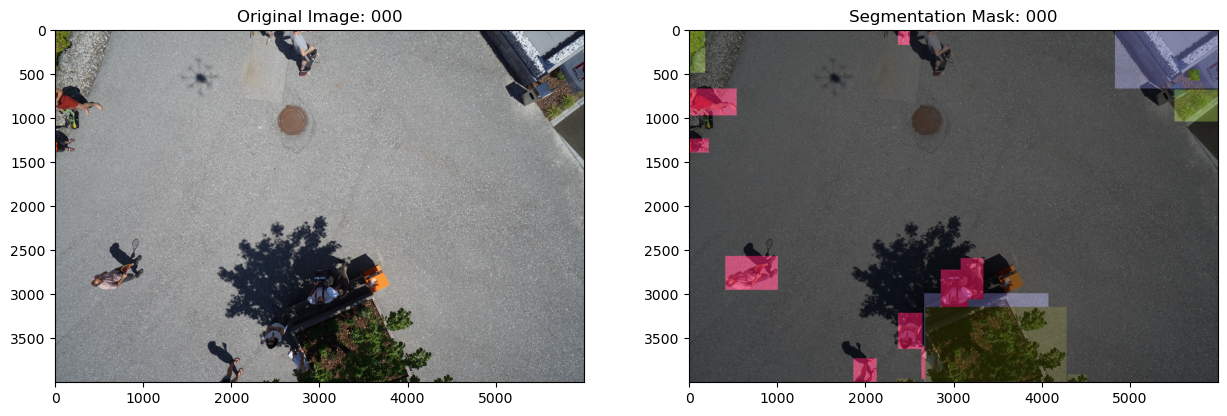

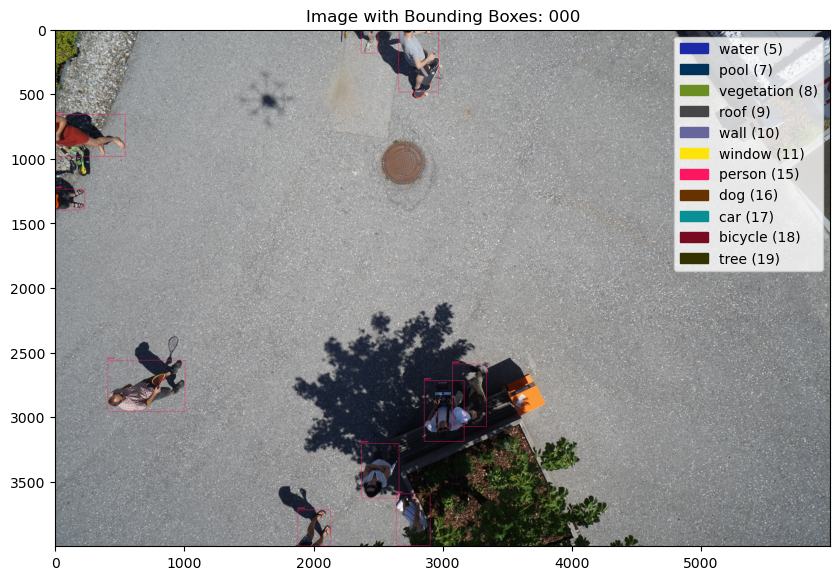

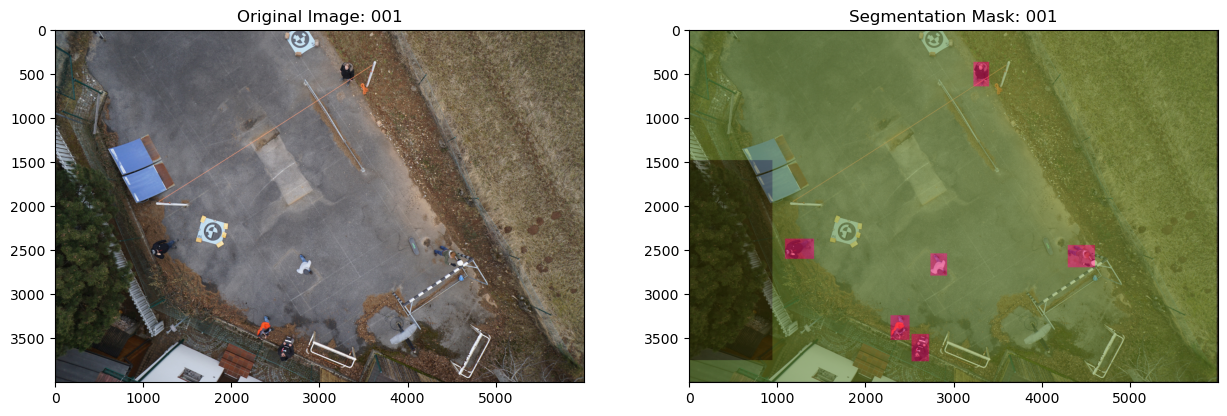

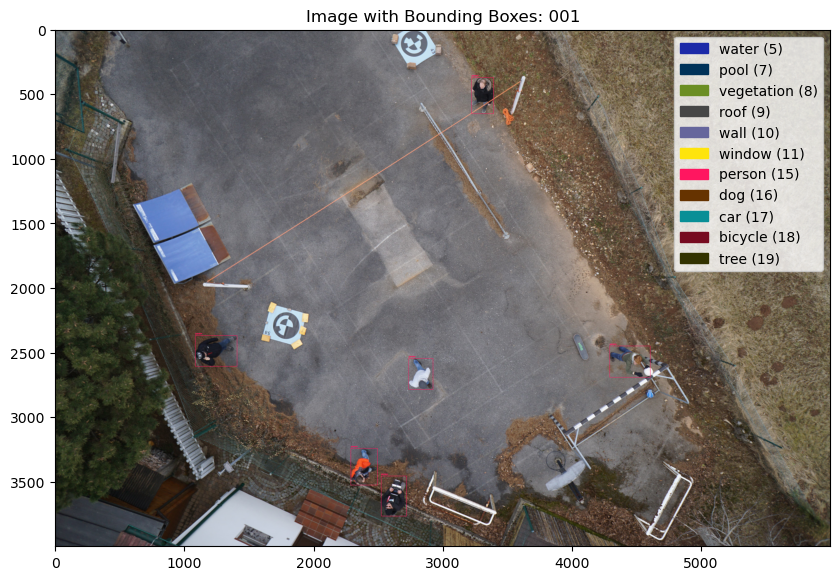

In [14]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Path to the dataset
dataset_path = "./dataset/new_dataset"
image_dir = os.path.join(dataset_path, "images")
segmentation_mask_dir = os.path.join(dataset_path, "segmentation_mask")
annotations_dir = os.path.join(dataset_path, "labels")

# Class ID to name mapping with RGB values
class_id_to_name = {
    5: ('water', [28, 42, 168]),
    7: ('pool', [0, 50, 89]),
    8: ('vegetation', [107, 142, 35]),
    9: ('roof', [70, 70, 70]),
    10: ('wall', [102, 102, 156]),
    11: ('window', [254, 228, 12]),
    15: ('person', [255, 22, 96]),
    16: ('dog', [102, 51, 0]),
    17: ('car', [9, 143, 150]),
    18: ('bicycle', [119, 11, 32]),
    19: ('tree', [51, 51, 0]),
}

# Function to load YOLO bounding box annotations
def load_yolo_annotations(anno_file):
    with open(anno_file, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to visualize the segmentation mask and bounding boxes
def visualize_data(image_id):
    # Load image
    img_path = os.path.join(image_dir, f"{image_id}.jpg")
    segmentation_mask_path = os.path.join(segmentation_mask_dir, f"{image_id}_segmentation_mask.png")
    annotation_path = os.path.join(annotations_dir, f"{image_id}.txt")
    
    if not os.path.exists(img_path) or not os.path.exists(segmentation_mask_path) or not os.path.exists(annotation_path):
        print(f"[WARNING] Missing files for {image_id}, skipping...")
        return

    # Load image and segmentation mask
    image = Image.open(img_path)
    image = np.array(image)
    segmentation_mask = Image.open(segmentation_mask_path)
    segmentation_mask = np.array(segmentation_mask)

    # Load YOLO annotations
    boxes = load_yolo_annotations(annotation_path)

    # Plotting the image with bounding boxes and segmentation mask overlay
    plt.figure(figsize=(15, 10))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original Image: {image_id}")
    
    # Plot segmentation mask with overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(segmentation_mask, alpha=0.5)  # Overlay segmentation mask with transparency
    plt.title(f"Segmentation Mask: {image_id}")

    # Draw bounding boxes on the image
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        class_name = class_id_to_name[int(class_id)][0]
        x_min = int((x_center - width / 2) * image.shape[1])
        y_min = int((y_center - height / 2) * image.shape[0])
        x_max = int((x_center + width / 2) * image.shape[1])
        y_max = int((y_center + height / 2) * image.shape[0])

        # Draw bounding box
        color = class_id_to_name[int(class_id)][1]
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image, class_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Show the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(f"Image with Bounding Boxes: {image_id}")

    # Add color legend to indicate class-to-color mapping
    legend_handles = []
    for class_id, (class_name, class_rgb) in class_id_to_name.items():
        color = np.array(class_rgb) / 255.0  # Normalize to [0, 1] range for plotting
        legend_handles.append(mpatches.Patch(color=color, label=f"{class_name} ({class_id})"))
    
    plt.legend(handles=legend_handles, loc='upper right', fontsize=10)
    plt.show()

# Loop through some example image IDs (you can specify more or iterate through the dataset)
image_ids = [img.split('.')[0] for img in os.listdir(image_dir) if img.endswith(".jpg")]
for image_id in image_ids[:2]:  # Visualizing first 5 images as an example
    visualize_data(image_id)


# Covert into train and val datset

In [15]:
import os
import shutil
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# Define paths
input_image_dir = "./dataset/new_dataset/images"
input_mask_dir = "./dataset/new_dataset/segmentation_mask"
input_annotation_dir = "./dataset/new_dataset/labels"
output_dir = "./dataset/suitable-dataset"  # New folder for final dataset

# Create directories for the train and val sets
train_image_dir = os.path.join(output_dir, 'train/images')
val_image_dir = os.path.join(output_dir, 'val/images')
train_mask_dir = os.path.join(output_dir, 'train/segmentation_mask')
val_mask_dir = os.path.join(output_dir, 'val/segmentation_mask')
train_annotation_dir = os.path.join(output_dir, 'train/labels')
val_annotation_dir = os.path.join(output_dir, 'val/labels')

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)
os.makedirs(train_annotation_dir, exist_ok=True)
os.makedirs(val_annotation_dir, exist_ok=True)

# List of all image files in the dataset
image_ids = [img.split('.')[0] for img in os.listdir(input_image_dir) if img.endswith('.jpg')]

# Split the dataset into train and val using a 80-20 split
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Helper function to move files to the appropriate directories
def move_files(file_list, source_image_dir, source_mask_dir, source_annotation_dir,
               target_image_dir, target_mask_dir, target_annotation_dir):
    for image_id in tqdm(file_list, desc="Moving files"):
        image_path = os.path.join(source_image_dir, f"{image_id}.jpg")
        mask_path = os.path.join(source_mask_dir, f"{image_id}_segmentation_mask.png")
        annotation_path = os.path.join(source_annotation_dir, f"{image_id}.txt")

        # Move image file
        if os.path.exists(image_path):
            shutil.copy(image_path, target_image_dir)
        
        # Move segmentation mask file
        if os.path.exists(mask_path):
            shutil.copy(mask_path, target_mask_dir)
        
        # Move YOLO annotation file
        if os.path.exists(annotation_path):
            shutil.copy(annotation_path, target_annotation_dir)

# Move training files
move_files(train_ids, input_image_dir, input_mask_dir, input_annotation_dir,
           train_image_dir, train_mask_dir, train_annotation_dir)

# Move validation files
move_files(val_ids, input_image_dir, input_mask_dir, input_annotation_dir,
           val_image_dir, val_mask_dir, val_annotation_dir)

print("✅ Dataset split into train and val, and files moved successfully.")


Moving files:   0%|          | 0/319 [00:00<?, ?it/s]

Moving files:   0%|          | 0/80 [00:00<?, ?it/s]

✅ Dataset split into train and val, and files moved successfully.


# Now train the dataset 

## Train on yolov8

In [18]:
import os
from ultralytics import YOLO

# Set environment variable to avoid issues with Intel MKL
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Load the YOLOv8 model (YOLOv8n, a smaller version)
model = YOLO("yolov8n.pt")

# Start the training process for YOLOv8
model.train(
    data="uavdt.yaml",  # Path to your dataset YAML file
    epochs=5,          # Number of training epochs
    imgsz=640,          # Image size (adjust if necessary)
    batch=32,           # Batch size
    show=True,          # Display training results in a window
    name="yolov8-uavdt",  # Name of the training run
    project="runs/train"  # Directory to store training outputs
)


Ultralytics 8.3.107  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=uavdt.yaml, epochs=5, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=yolov8-uavdt, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=True, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

train: Scanning C:\Users\sande\OneDrive\Desktop\IITTP\2_Asgn\Sem2\2_dl\SemProject\Automated_SegmentAndYolo\dataset\suitable-dataset\train\labels.cache... 319 images, 28 backgrounds, 0 corrupt: 100%|██████████| 319/319 [00:00<?, ?it/s]
val: Scanning C:\Users\sande\OneDrive\Desktop\IITTP\2_Asgn\Sem2\2_dl\SemProject\Automated_SegmentAndYolo\dataset\suitable-dataset\val\labels.cache... 80 images, 6 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]

Plotting labels to runs\train\yolov8-uavdt\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\yolov8-uavdt
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.888      5.065      1.311        194        640: 100%|██████████| 10/10 [01:51<00:00, 11.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.12s/it]

                   all         80        355          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.823      4.328      1.201        181        640: 100%|██████████| 10/10 [01:27<00:00,  8.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.60s/it]

                   all         80        355      0.144      0.318      0.228      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.861       2.73      1.179        233        640: 100%|██████████| 10/10 [01:25<00:00,  8.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.52s/it]

                   all         80        355      0.118      0.499      0.295      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/5         0G       1.69      2.126      1.124        204        640: 100%|██████████| 10/10 [01:24<00:00,  8.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.53s/it]

                   all         80        355      0.185      0.501      0.328      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.621      1.901      1.091        169        640: 100%|██████████| 10/10 [01:25<00:00,  8.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.49s/it]

                   all         80        355      0.209      0.577      0.429      0.224

5 epochs completed in 0.142 hours.


Optimizer stripped from runs\train\yolov8-uavdt\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\yolov8-uavdt\weights\best.pt, 6.2MB

Validating runs\train\yolov8-uavdt\weights\best.pt...
Ultralytics 8.3.107  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Model summary (fused): 72 layers, 3,008,768 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


                   all         80        355      0.209      0.577      0.429      0.224
                person         74        355      0.209      0.577      0.429      0.224
Speed: 1.9ms preprocess, 44.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\train\yolov8-uavdt


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([15])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001C716244BF0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048

## U-net for segmentation

In [8]:
import torch
import numpy as np
from PIL import Image

import torch
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
from tqdm.auto import tqdm



class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

        # Class ID to Name mapping (as provided by you)
        self.class_id_to_name = {
            5: ('water', [28, 42, 168]),
            7: ('pool', [0, 50, 89]),
            8: ('vegetation', [107, 142, 35]),
            9: ('roof', [70, 70, 70]),
            10: ('wall', [102, 102, 156]),
            11: ('window', [254, 228, 12]),
            15: ('person', [255, 22, 96]),
            16: ('dog', [102, 51, 0]),
            17: ('car', [9, 143, 150]),
            18: ('bicycle', [119, 11, 32]),
            19: ('tree', [51, 51, 0]),
        }
        
        # Re-mapping class ids to [0, 1, 2, ...]
        self.class_id_map = {orig_id: new_id for new_id, orig_id in enumerate(self.class_id_to_name.keys())}
        
        self.class_names = [name[0] for name in self.class_id_to_name.values()]  # Get class names

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('RGB')  # Load mask as RGB for color mapping

        # Resize images and masks to the same size (256, 256)
        image = image.resize((256, 256))
        mask = mask.resize((256, 256))

        # Convert mask to class indices using the provided class_id_to_name mapping
        mask = np.array(mask)
        mask = self.convert_mask_to_class_ids(mask)

        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.long)  # Convert mask to tensor

        return image, mask

    def convert_mask_to_class_ids(self, mask):
        # Create a mask of class ids based on the provided color-to-class mapping
        class_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
        
        for class_id, (_, color) in self.class_id_to_name.items():
            # Find all pixels that match the color
            color_mask = np.all(mask == color, axis=-1)
            class_mask[color_mask] = self.class_id_map[class_id]  # Remap to continuous class ids

        return class_mask


    
# ---------------------------
# Define the Dataset and Model
# ---------------------------

image_dir = './dataset/suitable-dataset/train/images'
mask_dir = './dataset/suitable-dataset/train/segmentation_mask'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Initialize Dataset and DataLoader
dataset = SegmentationDataset(image_dir, mask_dir, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.segmentation.deeplabv3_resnet101(pretrained=True)

# Modify the final layer to match the number of classes in your dataset
num_classes = len(dataset.class_names)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
model = model.to(device)

# ---------------------------
# Loss and Optimizer
# ---------------------------

criterion = nn.CrossEntropyLoss()  # for multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ---------------------------
# Training Loop
# ---------------------------

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        masks = masks.to(device)  # shape: [B, H, W]

        optimizer.zero_grad()
        output = model(images)['out']  # shape: [B, C, H, W]

        # Compute loss
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader)}")

# ---------------------------
# Save the model
# ---------------------------

torch.save(model.state_dict(), 'deeplabv3_model.pth')



Epoch 1/5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/5, Loss: 1.5699040055274964


Epoch 2/5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/5, Loss: 0.9989054054021835


Epoch 3/5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/5, Loss: 0.8634957790374755


Epoch 4/5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/5, Loss: 0.797741049528122


Epoch 5/5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/5, Loss: 0.7175007373094558


# Pridiciton

In [19]:
import os
from pathlib import Path
from ultralytics import YOLO

def find_best_pt(base_dir='runs/'):
    best_paths = list(Path(base_dir).rglob('best.pt'))
    if not best_paths:
        raise FileNotFoundError("No 'best.pt' file found in the 'runs/' directory.")
    
    # Optionally, sort by latest modified time
    best_paths.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    
    print(f"✅ Found best.pt at: {best_paths[0]}")
    return str(best_paths[0])

# Load the model
best_pt_path = find_best_pt()


✅ Found best.pt at: runs\train\yolov8-uavdt\weights\best.pt


In [23]:
# YOLO Detection
yolo_model = YOLO(best_pt_path)  # Load your YOLO model path

yolo_result = yolo_model.predict(source="./dataset/new_dataset/images/001.jpg", conf=0.3, save=False, verbose=False)[0]
print("YOLO Result:", yolo_result)
print("Boxes:", yolo_result.boxes)


YOLO Result: ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'unlabeled', 1: 'paved-area', 2: 'dirt', 3: 'grass', 4: 'gravel', 5: 'water', 6: 'rocks', 7: 'pool', 8: 'vegetation', 9: 'roof', 10: 'wall', 11: 'window', 12: 'door', 13: 'fence', 14: 'fence-pole', 15: 'person'}
obb: None
orig_img: array([[[111, 108, 103],
        [113, 110, 105],
        [115, 112, 107],
        ...,
        [ 66,  84,  91],
        [ 73,  85,  95],
        [ 75,  87,  97]],

       [[111, 108, 103],
        [112, 109, 104],
        [114, 111, 106],
        ...,
        [ 64,  82,  89],
        [ 68,  83,  92],
        [ 69,  84,  93]],

       [[111, 108, 103],
        [112, 109, 104],
        [113, 110, 105],
        ...,
        [ 61,  80,  87],
        [ 63,  80,  89],
        [ 63,  80,  89]],

       ...,

       [[ 57,  48,  44],
        [ 56,  47,  43],
        [ 55,  46,  42],
        ...,
        [ 49,

In [25]:
if yolo_result.boxes is None or len(yolo_result.boxes) == 0:
    print("⚠️ No objects detected by YOLO in this image.")
else:
    # proceed with drawing
    vis_image.show()  # to display only YOLO detections if any



⚠️ No objects detected by YOLO in this image.


c:\Users\sande\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sande\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


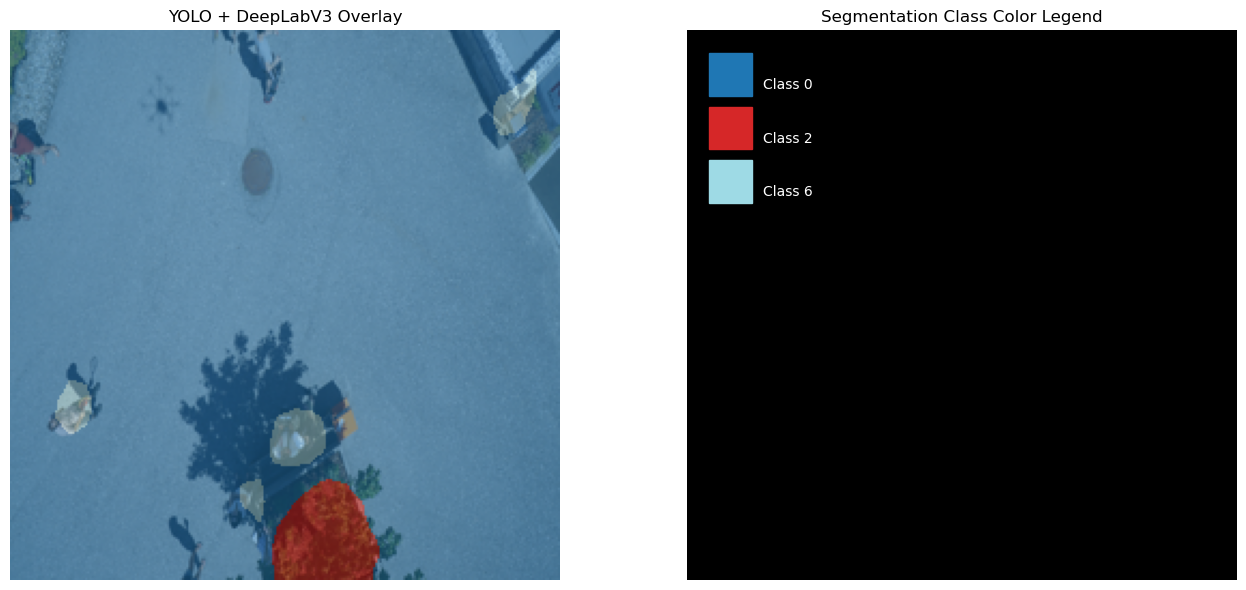

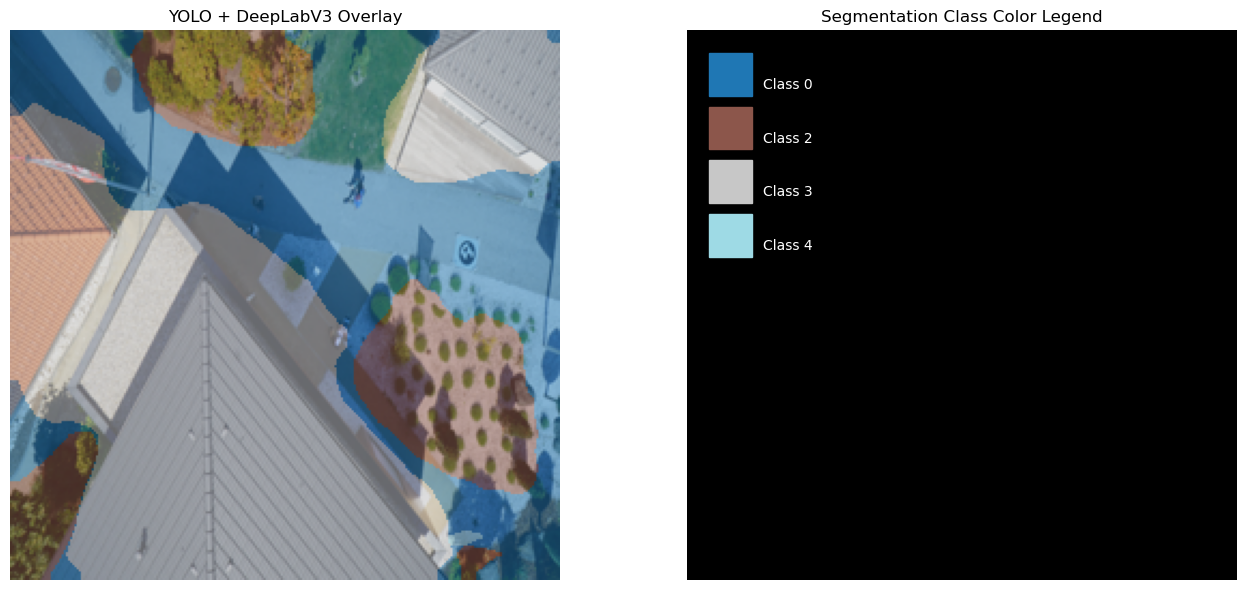

In [26]:
import torch
import torch.nn as nn
import torchvision.models.segmentation as segmentation
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os
from ultralytics import YOLO

%matplotlib inline


# ---------- 1. Load Models ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load DeepLabV3 with the desired number of output classes
deeplabv3_model = segmentation.deeplabv3_resnet101(pretrained=False)

deeplabv3_model.classifier[4] = nn.Conv2d(256, 11, kernel_size=(1, 1))  # Assuming 11 classes, as in saved model

# Load the state dict with strict=False to ignore auxiliary classifier weights
state_dict = torch.load('deeplabv3_model.pth', map_location=device)
deeplabv3_model.load_state_dict(state_dict, strict=False)

# Set the model to evaluation mode
deeplabv3_model.eval()


# Load YOLO model
yolo_model = YOLO(best_pt_path)  # Load your YOLO model path

def predict_and_visualize(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    original_image = Image.open(image_path).convert("RGB")
    input_tensor = transform(original_image).unsqueeze(0).to(device)

    # DeepLabV3 Semantic Segmentation
    with torch.no_grad():
        deeplabv3_output = deeplabv3_model(input_tensor)['out']
        seg_mask = torch.argmax(deeplabv3_output, dim=1).squeeze().cpu().numpy()

    # Resize original image for drawing
    vis_image = original_image.resize((256, 256)).copy()
    draw = ImageDraw.Draw(vis_image)

    # YOLO Detection
    yolo_result = yolo_model.predict(source=image_path, conf=0.3, save=False, verbose=False)[0]
    boxes = yolo_result.boxes
    labels = yolo_result.names
    confidences = boxes.conf
    coords = boxes.xywh

    # Draw YOLO bounding boxes
    for i in range(len(boxes)):
        box = coords[i]
        label = labels[int(boxes.cls[i])]
        confidence = confidences[i]

        # Convert to pixel coordinates on resized image
        x_center, y_center, w, h = box
        x1 = int((x_center - w / 2) * 256)
        y1 = int((y_center - h / 2) * 256)
        x2 = int((x_center + w / 2) * 256)
        y2 = int((y_center + h / 2) * 256)

        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1), f"{label} {confidence:.2f}", fill="red")

    # Create a color map and overlay the segmentation mask
    colormap = plt.get_cmap('tab20')
    seg_rgb = colormap(seg_mask / seg_mask.max())[:, :, :3]  # RGB channels only
    seg_rgb = (seg_rgb * 255).astype(np.uint8)
    seg_pil = Image.fromarray(seg_rgb)

    blended = Image.blend(vis_image, seg_pil, alpha=0.5)

    # Plot final image and class-color legend
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Left: merged image
    axs[0].imshow(blended)
    axs[0].set_title("YOLO + DeepLabV3 Overlay")
    axs[0].axis("off")

    # Right: segmentation legend
    unique_classes = np.unique(seg_mask)
    axs[1].imshow(np.zeros((256, 256, 3), dtype=np.uint8))  # Empty canvas
    axs[1].axis("off")
    axs[1].set_title("Segmentation Class Color Legend")

    # Plot legend text
    for idx, cls_id in enumerate(unique_classes):
        color = colormap(cls_id / seg_mask.max())
        axs[1].add_patch(plt.Rectangle((10, 10 + idx * 25), 20, 20, color=color))
        axs[1].text(35, 25 + idx * 25, f"Class {cls_id}", fontsize=10, va='center', color="white")

    plt.tight_layout()
    plt.show()


# ---------- 3. Run on test images ----------
test_dir = "./dataset/suitable-dataset/val/images"
test_images = sorted(os.listdir(test_dir))[:2]

for img_file in test_images:
    predict_and_visualize(os.path.join(test_dir, img_file))


# Predcition on videos and save the masks as frame wise

In [36]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from ultralytics import YOLO
from torchvision import transforms
from tqdm import tqdm

# ================== CONFIGURATION ==================

video_path = 'video.mp4'
unet_weights_path = 'unet_model.pth'

output_base = './video_outputs'
max_frames = 10  # Set to None for full video, or specify a number like 10, 50, etc.

# ================== CREATE OUTPUT FOLDERS ==================

frame_dir = os.path.join(output_base, 'frames')
mask_dir = os.path.join(output_base, 'masks')
label_dir = os.path.join(output_base, 'labels')
output_video_path = os.path.join(output_base, 'output_video.mp4')

os.makedirs(frame_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

# ================== LOAD MODELS ==================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load YOLOv8
yolo_model = YOLO(best_pt_path)

# Load UNet
unet_model = UNet(3, 1).to(device)
unet_model.load_state_dict(torch.load(unet_weights_path, map_location=device))
unet_model.eval()

# Transform for U-Net
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

# ================== PROCESS VIDEO ==================

cap = cv2.VideoCapture(video_path)
frame_count = 0
pbar = tqdm(total=max_frames if max_frames else int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), desc="Processing frames", leave=False)

# Get video properties for saving the output video
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define VideoWriter for output video (for saving frames with bounding boxes and masks)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use 'XVID' or other codecs
out_video = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret or (max_frames is not None and frame_count >= max_frames):
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame_rgb)

    # Run U-Net segmentation
    input_tensor = transform(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = torch.sigmoid(unet_model(input_tensor))[0, 0].cpu().numpy()
    mask_resized = (pred_mask * 255).astype(np.uint8)
    mask_resized = cv2.resize(mask_resized, (frame.shape[1], frame.shape[0]))

    # Run YOLO detection
    results = yolo_model(frame)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    class_ids = results[0].boxes.cls.cpu().numpy()

    # Draw bounding boxes on the frame for YOLO
    for box, cls in zip(boxes, class_ids):
        x1, y1, x2, y2 = box
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Green bounding box
        cv2.putText(frame, f"Class {int(cls)}", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)

    # Overlay the segmentation mask on the frame
    frame_with_mask = frame.copy()
    mask_colored = cv2.applyColorMap(mask_resized, cv2.COLORMAP_JET)  # Apply color to the mask
    alpha = 0.5  # Set the transparency level for overlay
    cv2.addWeighted(mask_colored, alpha, frame_with_mask, 1 - alpha, 0, frame_with_mask)

    # Save frame with detection and mask
    frame_file = os.path.join(frame_dir, f'frame_{frame_count:04d}.jpg')
    cv2.imwrite(frame_file, frame)

    # Save mask
    mask_file = os.path.join(mask_dir, f'mask_{frame_count:04d}.png')
    cv2.imwrite(mask_file, mask_resized)

    # Save detection labels in YOLO format
    label_file = os.path.join(label_dir, f'frame_{frame_count:04d}.txt')
    with open(label_file, 'w') as f:
        for box, cls in zip(boxes, class_ids):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            cx, cy = x1 + w / 2, y1 + h / 2
            cx /= frame.shape[1]
            cy /= frame.shape[0]
            w /= frame.shape[1]
            h /= frame.shape[0]
            f.write(f"{int(cls)} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

    # Write the frame with mask and bounding boxes to output video
    out_video.write(frame_with_mask)

    frame_count += 1
    pbar.update(1)

cap.release()
out_video.release()
pbar.close()

print(f"\n✅ Finished processing {frame_count} frames.")
print(f"Saved frames to: {frame_dir}")
print(f"Saved masks to: {mask_dir}")
print(f"Saved labels to: {label_dir}")
print(f"Saved video to: {output_video_path}")


Processing frames:   0%|          | 0/10 [00:00<?, ?it/s]


0: 384x640 (no detections), 41.6ms
Speed: 2.2ms preprocess, 41.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  10%|█         | 1/10 [00:00<00:01,  5.94it/s]


0: 384x640 (no detections), 41.4ms
Speed: 1.5ms preprocess, 41.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 44.0ms
Speed: 1.6ms preprocess, 44.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  30%|███       | 3/10 [00:00<00:00,  9.19it/s]


0: 384x640 (no detections), 40.6ms
Speed: 2.0ms preprocess, 40.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 35.8ms
Speed: 1.4ms preprocess, 35.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  50%|█████     | 5/10 [00:00<00:00, 10.39it/s]


0: 384x640 (no detections), 42.9ms
Speed: 1.4ms preprocess, 42.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 43.7ms
Speed: 2.1ms preprocess, 43.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  70%|███████   | 7/10 [00:00<00:00, 10.38it/s]


0: 384x640 (no detections), 40.4ms
Speed: 2.1ms preprocess, 40.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 39.4ms
Speed: 1.6ms preprocess, 39.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  90%|█████████ | 9/10 [00:00<00:00, 10.72it/s]


0: 384x640 (no detections), 34.0ms
Speed: 1.3ms preprocess, 34.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)



✅ Finished processing 10 frames.
Saved frames to: ./video_outputs\frames
Saved masks to: ./video_outputs\masks
Saved labels to: ./video_outputs\labels
Saved video to: ./video_outputs\output_video.mp4


# Eval;aute

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.metrics import average_precision_score
from collections import defaultdict

# ================== CONFIGURATION ==================
ground_truth_labels_dir = './ground_truth/labels'  # Path to ground truth labels
ground_truth_masks_dir = './ground_truth/masks'   # Path to ground truth masks
predicted_labels_dir = './video_outputs/labels'   # Path to predicted labels
predicted_masks_dir = './video_outputs/masks'     # Path to predicted masks

iou_threshold = 0.5  # IoU threshold for object detection evaluation
max_frames = 10      # Set to None for full evaluation

# ================== EVALUATE OBJECT DETECTION (YOLO-style) ==================

def calculate_iou(box1, box2):
    """
    Calculate IoU between two bounding boxes.
    Box format: [x1, y1, x2, y2]
    """
    x1, y1, x2, y2 = box1
    x1p, y1p, x2p, y2p = box2

    # Calculate intersection
    ix1 = max(x1, x1p)
    iy1 = max(y1, y1p)
    ix2 = min(x2, x2p)
    iy2 = min(y2, y2p)

    iw = max(0, ix2 - ix1)
    ih = max(0, iy2 - iy1)

    intersection = iw * ih
    area_box1 = (x2 - x1) * (y2 - y1)
    area_box2 = (x2p - x1p) * (y2p - y1p)

    union = area_box1 + area_box2 - intersection
    iou = intersection / union if union > 0 else 0

    return iou

def evaluate_object_detection():
    pred_files = sorted(os.listdir(predicted_labels_dir))[:max_frames]
    gt_files = sorted(os.listdir(ground_truth_labels_dir))[:max_frames]

    iou_scores = []
    for pred_file, gt_file in zip(pred_files, gt_files):
        pred_boxes = []
        gt_boxes = []

        # Read predicted labels
        with open(os.path.join(predicted_labels_dir, pred_file), 'r') as f:
            for line in f:
                cls, cx, cy, w, h = map(float, line.strip().split())
                x1 = (cx - w / 2)
                y1 = (cy - h / 2)
                x2 = (cx + w / 2)
                y2 = (cy + h / 2)
                pred_boxes.append([x1, y1, x2, y2])

        # Read ground truth labels
        with open(os.path.join(ground_truth_labels_dir, gt_file), 'r') as f:
            for line in f:
                cls, cx, cy, w, h = map(float, line.strip().split())
                x1 = (cx - w / 2)
                y1 = (cy - h / 2)
                x2 = (cx + w / 2)
                y2 = (cy + h / 2)
                gt_boxes.append([x1, y1, x2, y2])

        # Calculate IoU for each pair of predicted and ground truth boxes
        for pred_box in pred_boxes:
            iou_max = 0
            for gt_box in gt_boxes:
                iou = calculate_iou(pred_box, gt_box)
                if iou > iou_max:
                    iou_max = iou
            if iou_max >= iou_threshold:
                iou_scores.append(iou_max)

    mean_iou = np.mean(iou_scores) if iou_scores else 0
    print(f"Mean IoU for Object Detection: {mean_iou:.4f}")

# ================== EVALUATE SEGMENTATION (U-Net masks) ==================

def calculate_segmentation_iou(pred_mask, gt_mask):
    """
    Calculate IoU for segmentation masks.
    """
    intersection = np.sum((pred_mask == 1) & (gt_mask == 1))
    union = np.sum((pred_mask == 1) | (gt_mask == 1))
    iou = intersection / union if union > 0 else 0
    return iou

def evaluate_segmentation():
    pred_files = sorted(os.listdir(predicted_masks_dir))[:max_frames]
    gt_files = sorted(os.listdir(ground_truth_masks_dir))[:max_frames]

    iou_scores = []
    for pred_file, gt_file in zip(pred_files, gt_files):
        # Read predicted mask
        pred_mask = cv2.imread(os.path.join(predicted_masks_dir, pred_file), cv2.IMREAD_GRAYSCALE)
        pred_mask = (pred_mask > 127).astype(np.uint8)  # Thresholding to binary mask

        # Read ground truth mask
        gt_mask = cv2.imread(os.path.join(ground_truth_masks_dir, gt_file), cv2.IMREAD_GRAYSCALE)
        gt_mask = (gt_mask > 127).astype(np.uint8)  # Thresholding to binary mask

        # Calculate IoU for the mask
        iou = calculate_segmentation_iou(pred_mask, gt_mask)
        iou_scores.append(iou)

    mean_iou = np.mean(iou_scores) if iou_scores else 0
    print(f"Mean IoU for Segmentation: {mean_iou:.4f}")

# ================== MAIN EVALUATION PIPELINE ==================

def evaluate():
    print("Evaluating Object Detection...")
    evaluate_object_detection()
    
    print("\nEvaluating Segmentation...")
    evaluate_segmentation()

# Run evaluation
evaluate()


# 